In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Islamophhobia Detection with BERT using Keras and TensorFlow 2

In [4]:
!nvidia-smi

Thu Sep 24 15:27:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |    359MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install tensorflow-gpu 

     |████████████████████████████████| 320.4MB 44kB/s 


In [1]:
!pip install --upgrade grpcio

Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.32.0)


In [2]:
!pip install tqdm

In [3]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 2.7MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-cp36-none-any.whl size=30318 sha256=4f59ec86bb529b8fe20881170f2c973f4ed03e73e2daaab583874e5256009904
  Stored in directory: /root/.cache/pip/wheels/07/a0/b4/75b0601ebaa41e517a797fe9cea119c789664c8408f8a74ae9
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=628e173428df427e5ae7b296682cc0ab2f29ea354e222ba8e755c6b8d6b1c2f9
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=8cf39273a4d286390708327c9f2a3896ab7a1291b1cc74a0258b0a0a5dca7ddc
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [4]:
!pip install googletrans

     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 962kB 8.3MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 102kB 10.8MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=e7c5eda50a7c9ae666453dc5dda080bec72c26a80ccc232d106c1934eec36e17
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=abaeb25d24134fca90dd8a5cf668451d072e775acf241d8a64439015aa300c19
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [5]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 4.9MB/s 


In [6]:
!pip install googletrans

In [7]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

import re

# translator
import googletrans
from googletrans import Translator

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data


In [21]:
# Hindi data
!gdown --id 1EQRLvSUJn6VxFluTqNEGxXcV8_5OmCaW --output data-task3.csv

#Devnagri stopwards

!gdown --id 13c9q9suXTh_71Gi_GacAb-TBmsi3z1Ou --output stopwords.txt

Downloading...
From: https://drive.google.com/uc?id=1EQRLvSUJn6VxFluTqNEGxXcV8_5OmCaW
To: /content/data-task3.csv
100% 1.63M/1.63M [00:00<00:00, 108MB/s]
Downloading...
From: https://drive.google.com/uc?id=13c9q9suXTh_71Gi_GacAb-TBmsi3z1Ou
To: /content/stopwords.txt
100% 2.12k/2.12k [00:00<00:00, 3.23MB/s]


In [54]:
df = pd.read_csv('data-task3.csv', 
                   delimiter=',')
df.columns = ['Text', 'Label']
df.head(15)
df["Text"] = df["Text"].astype(str)
df["Label"] = df["Label"].astype(str)

In [55]:
df.Text[3]

"'अमीन के 500 से अधिक छात्रों ने सर्वे भवन के गेट पर आधा नंगा होकर किया प्रदर्शन  पप्पू यादव ने बुलंद की\\xa0आवाज"

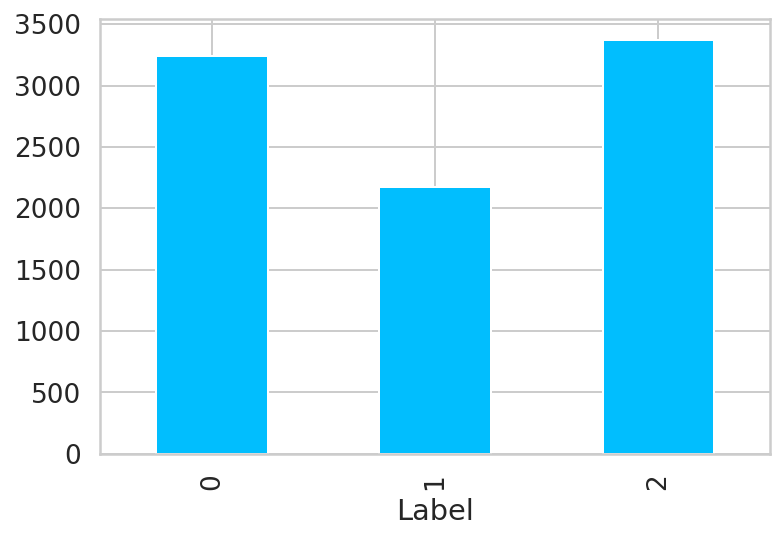

In [56]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [57]:
df.Label.value_counts()

2    3375
0    3244
1    2174
Name: Label, dtype: int64

In [58]:
df=df.sample(frac=1).reset_index(drop=True)
df

,Text,Label
0,हमें हिंदू के नाम पर बरगलाया जा रहा' पूर्व सा...,0
1,'बच्चों का भविष्य समाजवादी लैपटॉप सपा का काम...,0
2,'@_niikhii माशाअल्लाह बहुत खूबसूरत 😍😍 मुकर्रर ...,1
3,'सुशांत सिंह राजपूत की पोस्टमॉर्टम रिपोर्ट पर ...,0
4,'@SushantBSinha इस्लाम का मतलब ही आतंकवाद है ...,2
...,...,...
8788,'@SrBachchan किसी की भी हो कोई फर्क नहीं पडता ...,2
8789,'@arnab5222 कौन अगला सुशांत सिंह राजपूत की मौत...,0
8790,'@RehanSi68105058 @Asli_Shivani Madarcho chusa...,2
8791,'@ayaz_ayazkhan51 @HansrajMeena हम तो अंधभक्त ...,2


Data Preprocessing

In [59]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"@", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

df['Text'] = df['Text'].apply(lambda x: textPattern(x))

In [60]:
stopword=open("stopwords.txt","r")
stop_words=[]
# pre-process stopword
for i in stopword:
    i = re.sub('[\n]', '', i)
    stop_words.append(i)
hin_stopwords = set(stop_words) 

In [61]:
df = df[df.Text != '']

In [62]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.10, random_state=42)

In [63]:
df.head()

,Text,Label
0,हमें हिंदू के नाम पर बरगलाया जा रहा पूर्व सांस...,0
1,बच्चों का भविष्य समाजवादी लैपटॉप सपा का काम ज...,0
2,_niikhii माशाअल्लाह बहुत खूबसूरत 😍😍 मुकर्रर म...,1
3,सुशांत सिंह राजपूत की पोस्टमॉर्टम रिपोर्ट पर ...,0
4,SushantBSinha इस्लाम का मतलब ही आतंकवाद है मु...,2


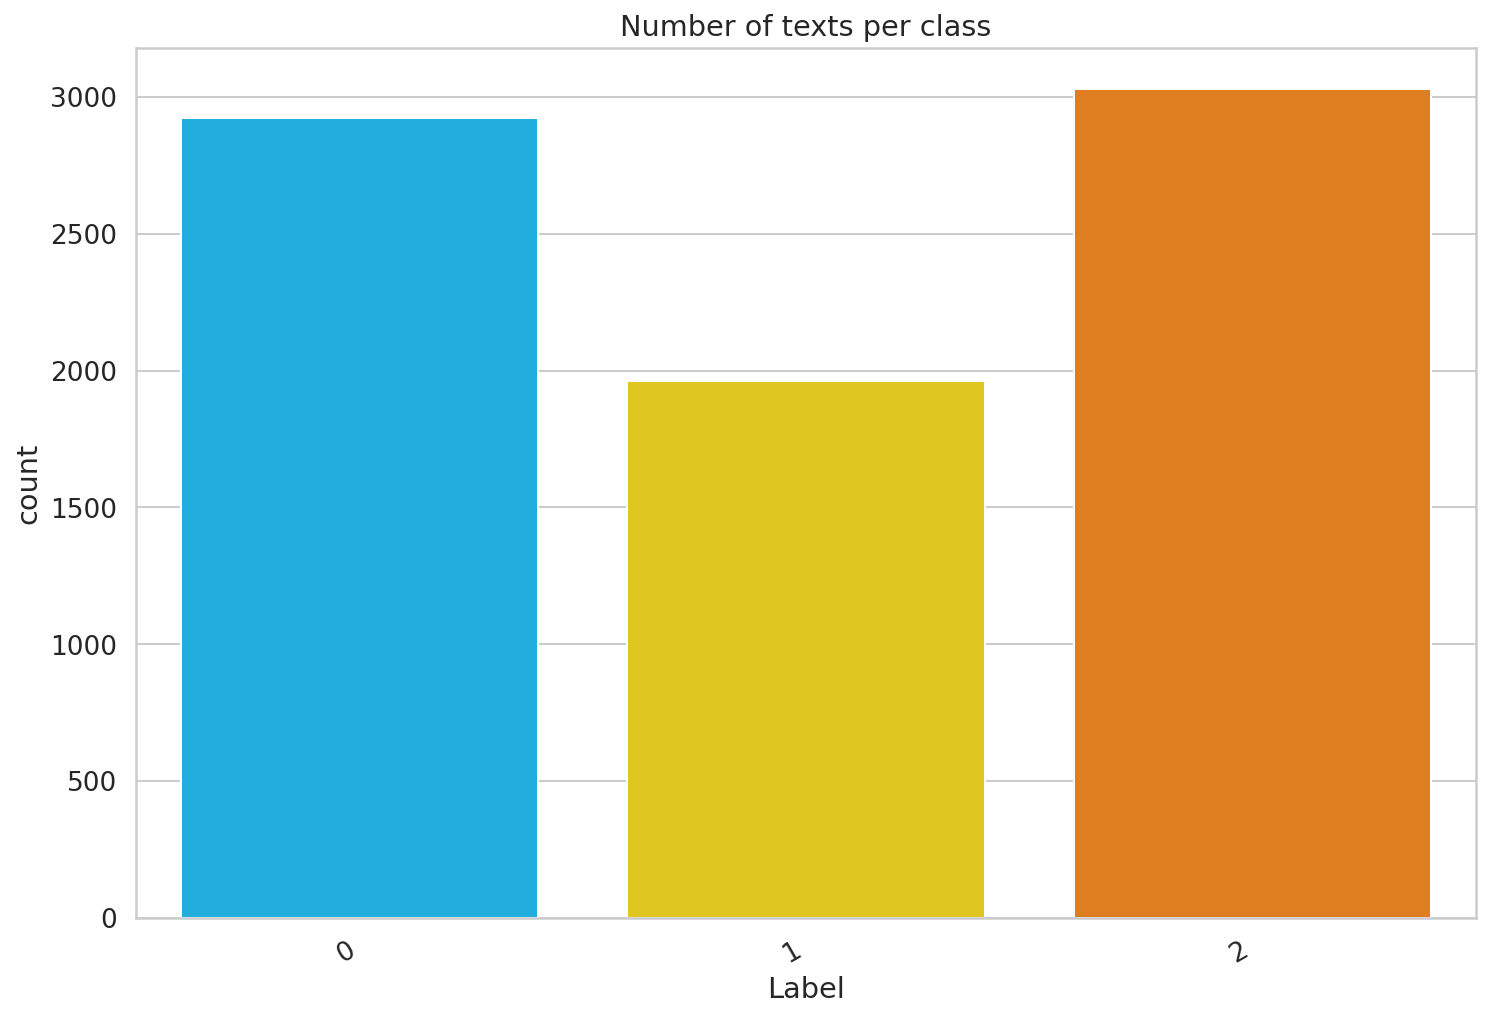

In [64]:
chart = sns.countplot(train.Label, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per class")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

# Islamophhobia Detection with BERT


In [65]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-09-24 19:45:38--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 74.125.28.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.1’

uncased_L-12_H-768_ 100%[===================>] 388.84M   143MB/s    in 2.7s    

2020-09-24 19:45:41 (143 MB/s) - ‘uncased_L-12_H-768_A-12.zip.1’ saved [407727028/407727028]



In [66]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [67]:
os.makedirs("model", exist_ok=True)

In [68]:
!mv uncased_L-12_H-768_A-12/ model

mv: cannot move 'uncased_L-12_H-768_A-12/' to 'model/uncased_L-12_H-768_A-12': Directory not empty


In [69]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [70]:
class IslamophobiaDetectionData:
  DATA_COLUMN = "Text"
  LABEL_COLUMN = "Label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IslamophobiaDetectionData.DATA_COLUMN], row[IslamophobiaDetectionData.LABEL_COLUMN]
      tokenss = self.tokenizer.tokenize(text)
      words = [w for w in tokenss if not w in hin_stopwords]
      tokens= words
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [71]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [72]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  #print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)

  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)


  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
  
  model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)
        
  return model

## Training

In [73]:
classes = train.Label.unique().tolist()

data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)

7913it [00:03, 2254.80it/s]
880it [00:00, 2322.60it/s]


max seq_len 213


In [74]:
model = create_model(data.max_seq_len, bert_ckpt_file)

Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4a90b98d30> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [75]:
model.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda_11 (Lambda)           (None, 768)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 768)               590592    
_________________________________________________________________
dropout_23 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 3)               

In [76]:


history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5
)

Epoch 1/5
446/446 [==============================] - 154s 346ms/step - loss: 0.8938 - acc: 0.6340 - val_loss: 0.6374 - val_acc: 0.9091
Epoch 2/5
446/446 [==============================] - 151s 339ms/step - loss: 0.6264 - acc: 0.9250 - val_loss: 0.6162 - val_acc: 0.9343
Epoch 3/5
446/446 [==============================] - 151s 340ms/step - loss: 0.6149 - acc: 0.9347 - val_loss: 0.6105 - val_acc: 0.9381
Epoch 4/5
446/446 [==============================] - 151s 339ms/step - loss: 0.6095 - acc: 0.9423 - val_loss: 0.6099 - val_acc: 0.9432
Epoch 5/5
446/446 [==============================] - 151s 339ms/step - loss: 0.6061 - acc: 0.9438 - val_loss: 0.6013 - val_acc: 0.9508


## Evaluation

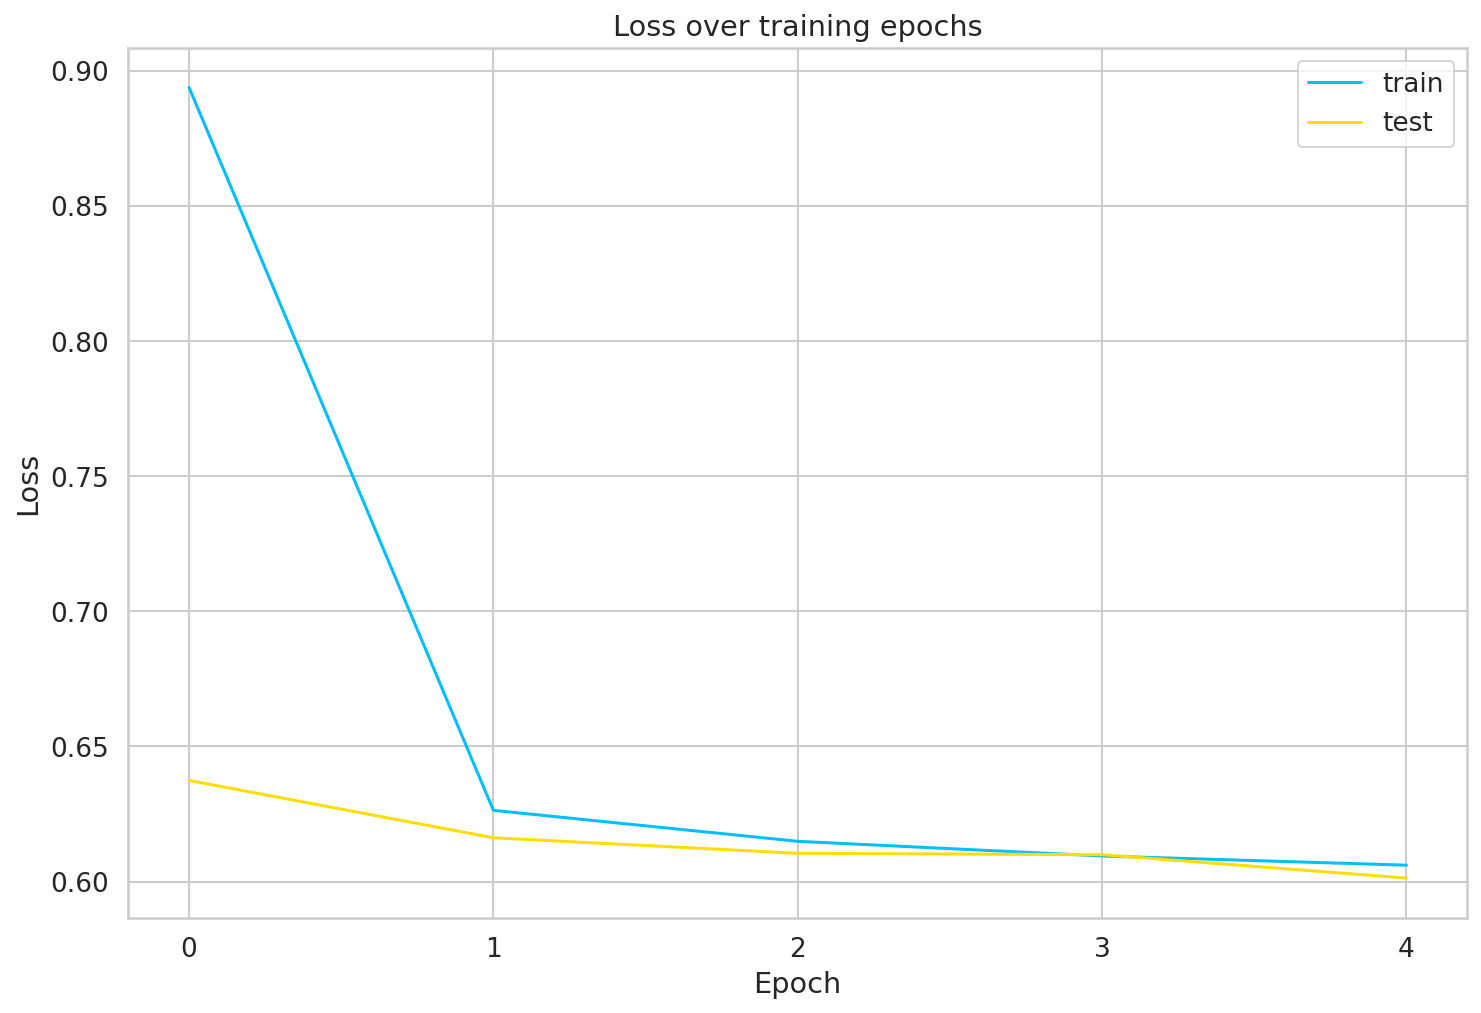

In [77]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

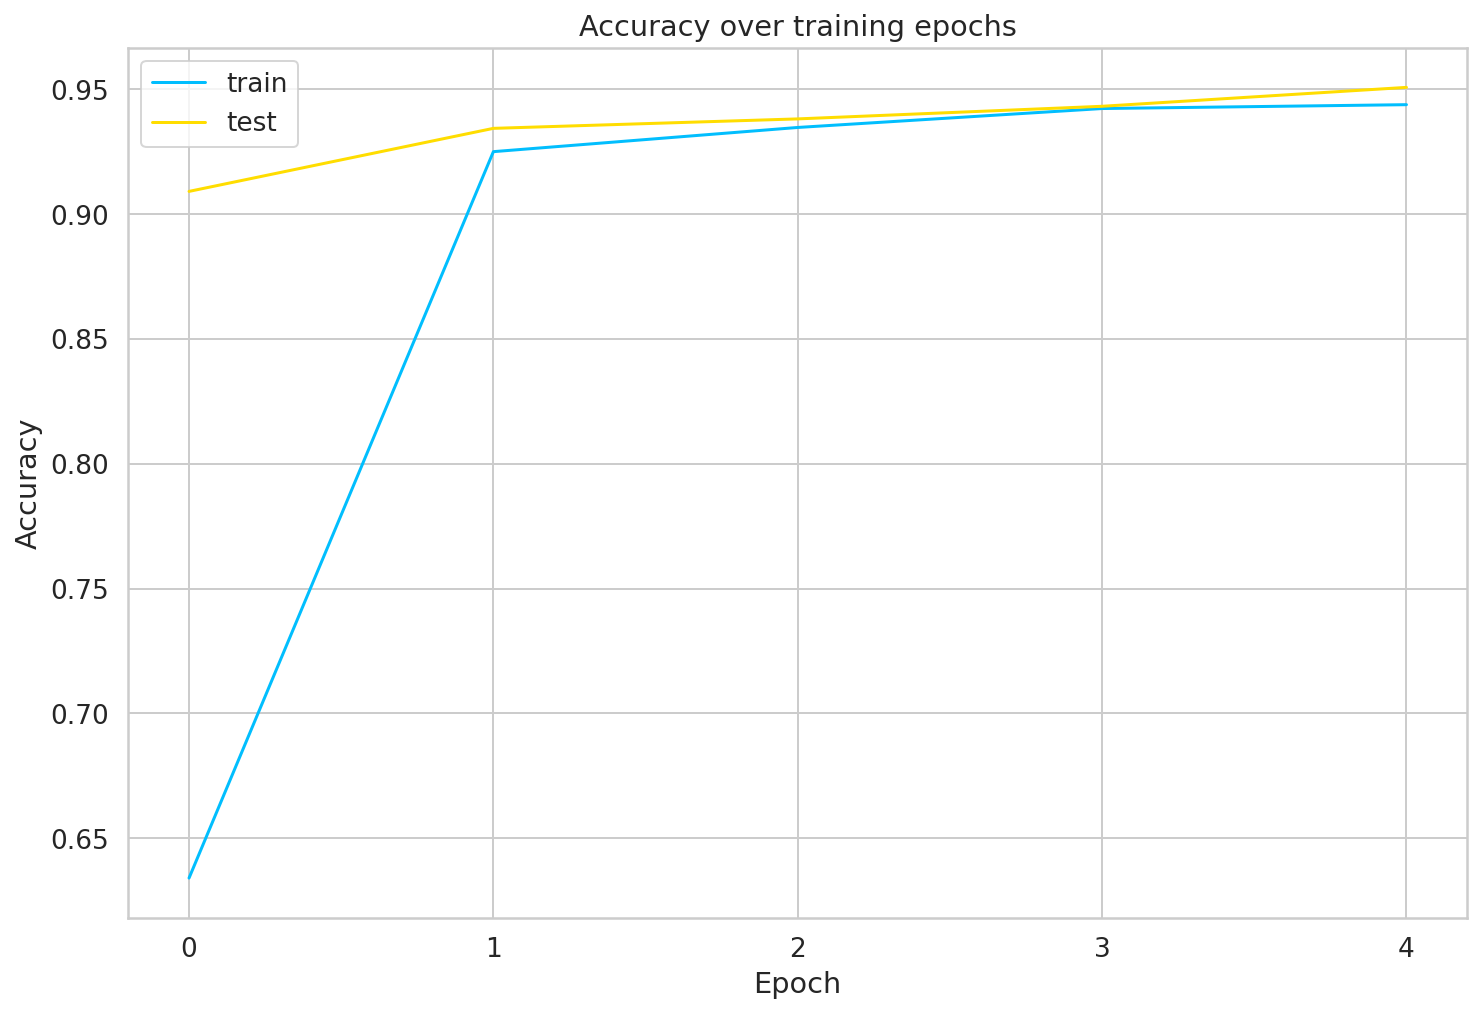

In [78]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [79]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

28/28 [==============================] - 5s 163ms/step - loss: 0.6044 - acc: 0.9455
train acc 0.9558953642845154
test acc 0.9454545378684998


In [80]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [81]:
print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       347
           1       0.92      0.93      0.93       212
           2       0.95      0.94      0.95       321

    accuracy                           0.95       880
   macro avg       0.94      0.94      0.94       880
weighted avg       0.95      0.95      0.95       880



In [82]:

cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

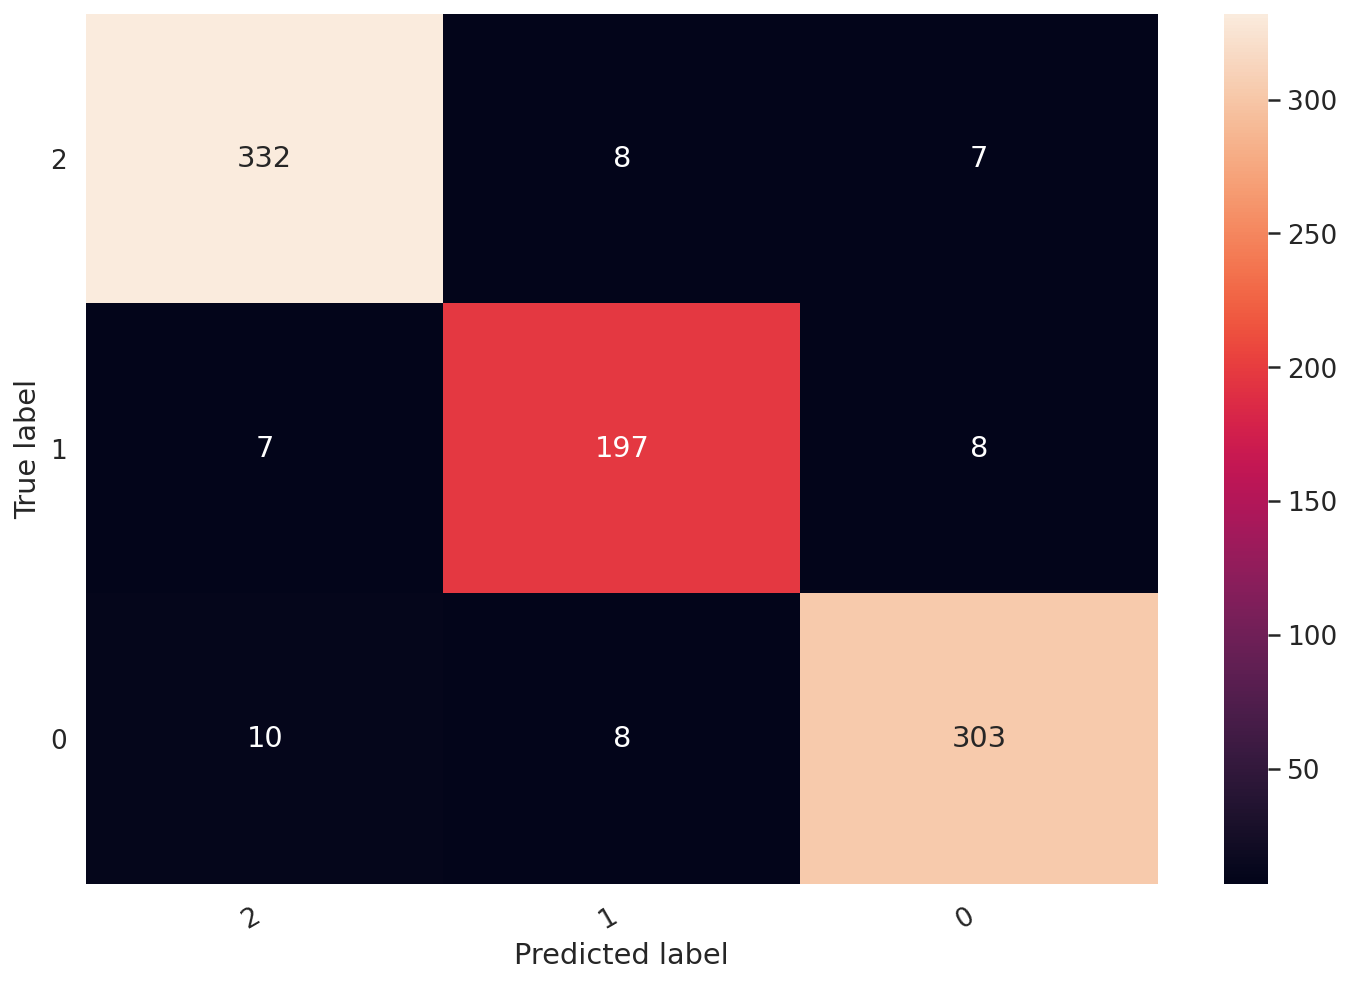

In [83]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# 10 Fold cross validation

In [84]:
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

kFold = 10

#To get accuracy of the model for 10 different splits
scores = []
training_accuracy = []
testing_accuracy = []
print("BERT: ")
for i in range(kFold):
    print('Fold ', i+1)
    print('')
    # Splitting data into test and train
    train, test = train_test_split(df, test_size=0.10, shuffle = True)

    classes = train.Label.unique().tolist()
    data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)
    model = create_model(data.max_seq_len, bert_ckpt_file)
    history = model.fit( x=data.train_x, y=data.train_y,validation_split=0.1,batch_size=16, shuffle=True,epochs=5)
    #train_loss, train_acc = model.evaluate(data.train_x, data.train_y)
    test_loss, test_acc = model.evaluate(data.test_x, data.test_y)
    
    #training_accuracy.append(train_acc)
    testing_accuracy.append(test_acc)

    y_pred = model.predict(data.test_x).argmax(axis=-1)

    scoreValue =accuracy_score(data.test_y, y_pred)
    scores.append(scoreValue)


248it [00:00, 2478.35it/s]

BERT: 
Fold  1



7913it [00:03, 2309.15it/s]
880it [00:00, 2288.47it/s]


max seq_len 213
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f498ddf3780> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 154s 346ms/step - loss: 0.8222 - acc: 0.7086 - val_loss: 0.6350 - val_acc: 0.9116
Epoch 2/5
446/446 [==============================] - 149s 335ms/step - loss: 0.6282 - acc: 0.9223 - val_loss: 0.6226 - val_acc: 0.9280
Epoch 3/5
446/446 [==============================] - 149s 335ms/step - loss

231it [00:00, 2308.33it/s]

Fold  2



7913it [00:03, 2349.58it/s]
880it [00:00, 2314.18it/s]


max seq_len 213
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4a9a757518> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 152s 342ms/step - loss: 0.8955 - acc: 0.6242 - val_loss: 0.6651 - val_acc: 0.8813
Epoch 2/5
446/446 [==============================] - 150s 336ms/step - loss: 0.6399 - acc: 0.9112 - val_loss: 0.6315 - val_acc: 0.9167
Epoch 3/5
446/446 [==============================] - 150s 336ms/step - loss

235it [00:00, 2346.37it/s]

Fold  3



7913it [00:03, 2373.53it/s]
880it [00:00, 2318.46it/s]


max seq_len 213
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f471ab7e860> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 153s 344ms/step - loss: 0.9406 - acc: 0.5769 - val_loss: 0.6415 - val_acc: 0.9078
Epoch 2/5
446/446 [==============================] - 151s 338ms/step - loss: 0.6277 - acc: 0.9229 - val_loss: 0.6335 - val_acc: 0.9154
Epoch 3/5
446/446 [==============================] - 151s 338ms/step - loss

231it [00:00, 2300.04it/s]

Fold  4



7913it [00:03, 2358.74it/s]
880it [00:00, 2403.67it/s]


max seq_len 213
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4bde35a828> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 153s 344ms/step - loss: 0.8351 - acc: 0.6972 - val_loss: 0.6356 - val_acc: 0.9141
Epoch 2/5
446/446 [==============================] - 151s 339ms/step - loss: 0.6271 - acc: 0.9242 - val_loss: 0.6216 - val_acc: 0.9280
Epoch 3/5
446/446 [==============================] - 151s 338ms/step - loss

235it [00:00, 2347.58it/s]

Fold  5



7913it [00:04, 1827.83it/s]
880it [00:00, 2302.10it/s]


max seq_len 213
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4949918630> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 153s 344ms/step - loss: 0.8305 - acc: 0.7058 - val_loss: 0.6442 - val_acc: 0.9040
Epoch 2/5
446/446 [==============================] - 151s 338ms/step - loss: 0.6244 - acc: 0.9259 - val_loss: 0.6352 - val_acc: 0.9141
Epoch 3/5
446/446 [==============================] - 151s 338ms/step - loss

238it [00:00, 2371.06it/s]

Fold  6



7913it [00:03, 2337.36it/s]
880it [00:00, 2296.62it/s]


max seq_len 213
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4bbfe5cc50> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 153s 344ms/step - loss: 0.8655 - acc: 0.6576 - val_loss: 0.6192 - val_acc: 0.9331
Epoch 2/5
446/446 [==============================] - 151s 339ms/step - loss: 0.6229 - acc: 0.9281 - val_loss: 0.6137 - val_acc: 0.9381
Epoch 3/5
446/446 [==============================] - 151s 339ms/step - loss

233it [00:00, 2318.12it/s]

Fold  7



7913it [00:03, 2326.10it/s]
880it [00:00, 2264.88it/s]


max seq_len 213
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4a92ec0390> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 154s 345ms/step - loss: 0.8463 - acc: 0.6835 - val_loss: 0.6152 - val_acc: 0.9343
Epoch 2/5
446/446 [==============================] - 151s 339ms/step - loss: 0.6241 - acc: 0.9268 - val_loss: 0.6100 - val_acc: 0.9407
Epoch 3/5
446/446 [==============================] - 152s 340ms/step - loss

231it [00:00, 2299.02it/s]

Fold  8



7913it [00:03, 2340.68it/s]
880it [00:00, 2324.12it/s]


max seq_len 213
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f498f5bbc18> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 154s 345ms/step - loss: 0.8884 - acc: 0.6391 - val_loss: 0.6671 - val_acc: 0.8838
Epoch 2/5
446/446 [==============================] - 151s 340ms/step - loss: 0.6257 - acc: 0.9252 - val_loss: 0.6154 - val_acc: 0.9356
Epoch 3/5
446/446 [==============================] - 151s 339ms/step - loss

242it [00:00, 2411.61it/s]

Fold  9



7913it [00:03, 2354.40it/s]
880it [00:00, 2249.17it/s]


max seq_len 213
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4bbd4ff898> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 155s 347ms/step - loss: 0.7916 - acc: 0.7485 - val_loss: 0.6324 - val_acc: 0.9167
Epoch 2/5
446/446 [==============================] - 152s 340ms/step - loss: 0.6253 - acc: 0.9256 - val_loss: 0.6322 - val_acc: 0.9179
Epoch 3/5
446/446 [==============================] - 151s 340ms/step - loss

247it [00:00, 2459.85it/s]

Fold  10



7913it [00:03, 2344.07it/s]
880it [00:00, 2346.53it/s]


max seq_len 213
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f479df62080> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 153s 343ms/step - loss: 0.8568 - acc: 0.6724 - val_loss: 0.6489 - val_acc: 0.8990
Epoch 2/5
446/446 [==============================] - 151s 338ms/step - loss: 0.6262 - acc: 0.9235 - val_loss: 0.6358 - val_acc: 0.9154
Epoch 3/5
446/446 [==============================] - 151s 338ms/step - loss

In [85]:

print('')
Mean_score = sum(scores) / len(scores)
print(f" Mean predict: {Mean_score}" )

mean_test = sum(testing_accuracy)/len(testing_accuracy)
print(f" Mean testing accuracy for 10 folds: {mean_test}" )


 Mean predict: 0.9351136363636362
 Mean testing accuracy for 10 folds: 0.9351136386394501


In [86]:
translator = Translator()
sentences = []
# 1
hin_text =  "इसलाम सुंदर है"
sentences.append(hin_text)

trans = translator.translate(hin_text, dest='en')

sentences.append(trans.text)

# 0
hin_text =  " समाज वादी  पार्टी  जिंदाबाद "
sentences.append(hin_text)

trans = translator.translate(hin_text, dest='en')

sentences.append(trans.text)

# 2
hin_text =  "'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"
sentences.append(hin_text)

trans = translator.translate(hin_text, dest='en')

sentences.append(trans.text)

# 2
hin_text = "UK ने भारत को लुटा था अब जिहादी UK को लुटने पोहँच गए। जो करोगे सो भरोगे।"
sentences.append(hin_text)

trans = translator.translate(hin_text, dest='en')

sentences.append(trans.text)

# 2
sentences.append( "Play our song now you asshole jehadi muslim")

# 0
sentences.append( "Rate this book as awful")


pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nLabel:", classes[label])
  print()

text: इसलाम सुंदर है 
Label: 1

text: Islam is beautiful 
Label: 1

text:  समाज वादी  पार्टी  जिंदाबाद  
Label: 0

text: Samajwadi Party Zindabad 
Label: 2

text: 'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂 
Label: 0

text: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂 
Label: 2

text: UK ने भारत को लुटा था अब जिहादी UK को लुटने पोहँच गए। जो करोगे सो भरोगे। 
Label: 2

text: The UK had looted India, now the jihadis looted the UK. Whatever you do will be filled. 
Label: 2

text: Play our song now you asshole jehadi muslim 
Label: 2

text: Rate this book as awful 
Label: 1



# Reference

1. Movie Reviews with bert-for-tf2 https://colab.research.google.com/drive/1esTDT7S7-31Uiwr8Hj1meV1aokeo8AYX?authuser=1